# Introduction

This Jupyter Notebook was crafted as part of my Minor in Microtecnology, Processing and Devices (MPD) at The Hague University of Applied Sciences. While drawing inspiration from the work of previous students (Niek van Koolwijk and Lucas Sluitman), I've tailored the code for cross-platform functionality. This adjustment was necessary as I, Emma Bajmat, encountered compatibility issues on my Mac.

To enhance clarity, I've organized the code into multiple Python scripts, prioritizing a clear and comprehensive depiction of the processes. While it may not strictly adhere to conventional principles of good code, I believe that in this context, prioritizing clarity is favourable.

## Imports & Path decleration

Imported below are the scripts utilized for this project. If you wish to import additional libraries, please do so in this section. In a subsequent cell, you will be prompted to specify the path to the image you intend to analyze.

In [1]:
import cv2
import numpy as np
from pytools_lithography.analysis.legacy.ImageFunctions import Image
from pytools_lithography.analysis.legacy.ImageAnalyzer import Analyzer
from tests.utils import get_test_img_path
import matplotlib.pyplot as plt

%matplotlib inline

Make it easy on yourself and keep one path for all your analyses ... otherwise you will get a different path everywhere and suddenly you are editing three different images. 

In [2]:
path = 'legacy_analysis_test.jpg'
path = get_test_img_path(path)

# Read image an crop

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Get scale from SEM image: S = (0.1176 ± 0.0001) µm/pixel
Get mean line width: d = (12.62 ± 0.13) µm


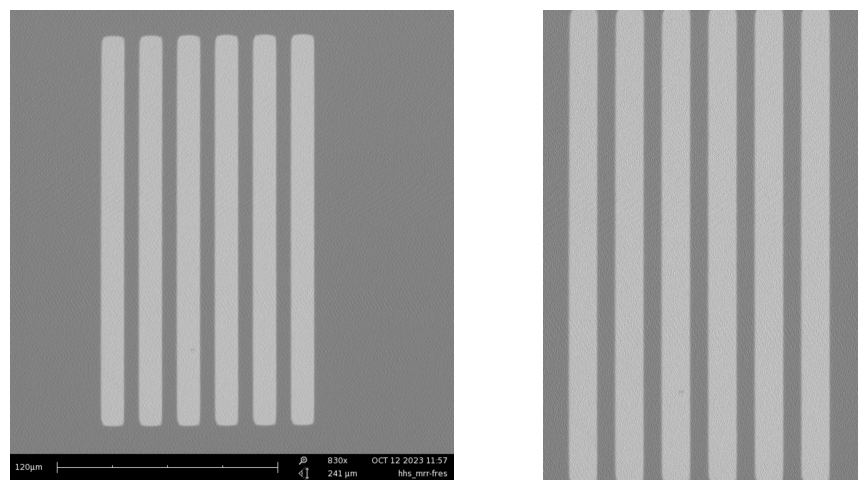

In [3]:
# Initialize an Image, this is a custom type to enable further analysis
img = Image(cv2.imread(path, cv2.IMREAD_UNCHANGED))

# This Image class makes it possible to call multiple functions
# For example calling the get_scale and get_line_width functions
scale, scale_pm = img.get_scale(return_pm = True)
line_width, line_width_pm, _ = img.get_line_width()

print(f'Get scale from SEM image: S = ({scale:.4f} ± {scale_pm:.4f}) µm/pixel')
print(f'Get mean line width: d = ({line_width:.2f} ± {line_width_pm:.2f}) µm')

# Show the original image and the cropped one
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].imshow(img.image, cmap = 'gray')
ax[0].axis('off')
ax[1].imshow(img.get_cropped_img(), cmap = 'gray')
ax[1].axis('off')
plt.tight_layout()

# Plot slice width

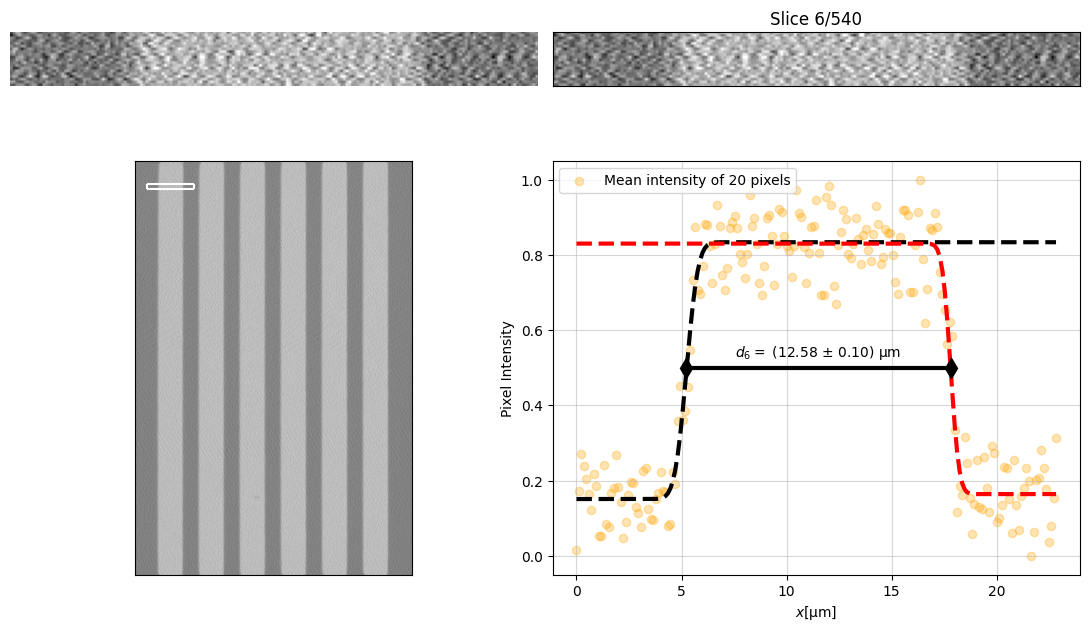

In [4]:
from scipy.special import erf

n = 100


def error_function(x: np.array, amplitude, x_offset, sigma, y_offset) -> np.array:
    diff = x - x_offset
    erf_term = erf(diff / (sigma * np.sqrt(2)))
    y = amplitude * 0.5 * (1 + erf_term) + y_offset
    return np.array(y)

y = img.get_normalized_split(0)
x = np.arange(len(y))

cons1, cons2, covar1, covar2 = img.analyzer._fit_data(x, y, True)
scaled_x = x * scale

xs1 = cons1[1] * scale
xs2 = cons2[1] * scale

xs1pm = cons1[1] * (scale - scale_pm)
xs2pm = cons2[1] * (scale + scale_pm)

width = xs2 - xs1
width_pm = 3 * (covar1[1] * scale + covar2[1] * scale + (xs2pm - xs1pm) - width)
width_pm = width * (((covar1[1] + covar2[1]) / (cons2[1] - cons1[1])) ** 2 + (scale_pm / scale) ** 2 )**0.5


fig, ax = plt.subplots(2, 2, figsize = (11, 8))
ax[1, 1].scatter(scaled_x, y, alpha = 0.3, color = 'orange', label = 'Mean intensity of 20 pixels')
ax[1, 1].plot(scaled_x, error_function(x, *cons1), linestyle = '--', lw = 3, color='black')
ax[1, 1].plot(scaled_x, error_function(x, *cons2), linestyle = '--', lw = 3, color='red')
ax[1, 1].set_xlabel('$x$[µm]')
ax[1, 1].set_ylabel('Pixel Intensity')
ax[1, 1].grid(alpha = 0.5)
  
ax[1, 1].plot([xs1, xs2], [0.5, 0.5], marker = 'd', color='black', lw = 3, markersize = 10)
ax[1, 1].text((xs1 + xs2) / 2, 0.53, f'$d_6 =$ ({width:.2f} $\pm$ {width_pm:.2f}) µm', ha = 'center')
ax[1, 1].set_aspect('auto')
ax[1, 1].legend(ncol = 3)

ax[0, 1].set_title('Slice 6/540')
ax[0, 1].imshow(img.get_splitted_img()[1][n:n+20, :], cmap='gray')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

img2 = img.get_splitted_img()[1][n:n+20, :]
ax[0, 0].imshow(img2, cmap='gray')
ax[0, 0].axis('off')

ax[1, 0].imshow(img.get_cropped_img(), cmap = 'gray')
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])
ax[1, 0].hlines(n, 50, 250, color = 'white')
ax[1, 0].hlines(n + 20, 50, 250, color = 'white')
ax[1, 0].vlines(50, n, n + 20, color = 'white')
ax[1, 0].vlines(250, n, n + 20, color = 'white')

plt.tight_layout()